In [1]:
#!pip -q install einops
import numpy as np
import torch
from torch.utils.data import DataLoader
from set_data import load_real_weather, WeatherPairs, split_windows_train_val_test
from visualization import (plot_complete_data, 
                           plot_weatherpair_panel,
                           visualize_loss, plot_ctx_and_scenarios_panel)
from utils import *
from diffusion_model import DiffusionSchedule, TinyCondUNet1D
from diffusion_model_train import train_one_epoch, eval_epoch
from diffusion_model_generate import p_sample_loop

VARS = 6
EPOCHS = 30
feature_names = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)



device: cpu


In [2]:

X, columns = load_real_weather("../../data/data_20150630_to_20250630.csv", 
                      start_date="2015-06-30", end_date="2024-06-30")
print("Real data shape:", X.shape)  # (days, number of features)

Real data shape: (3289, 6)


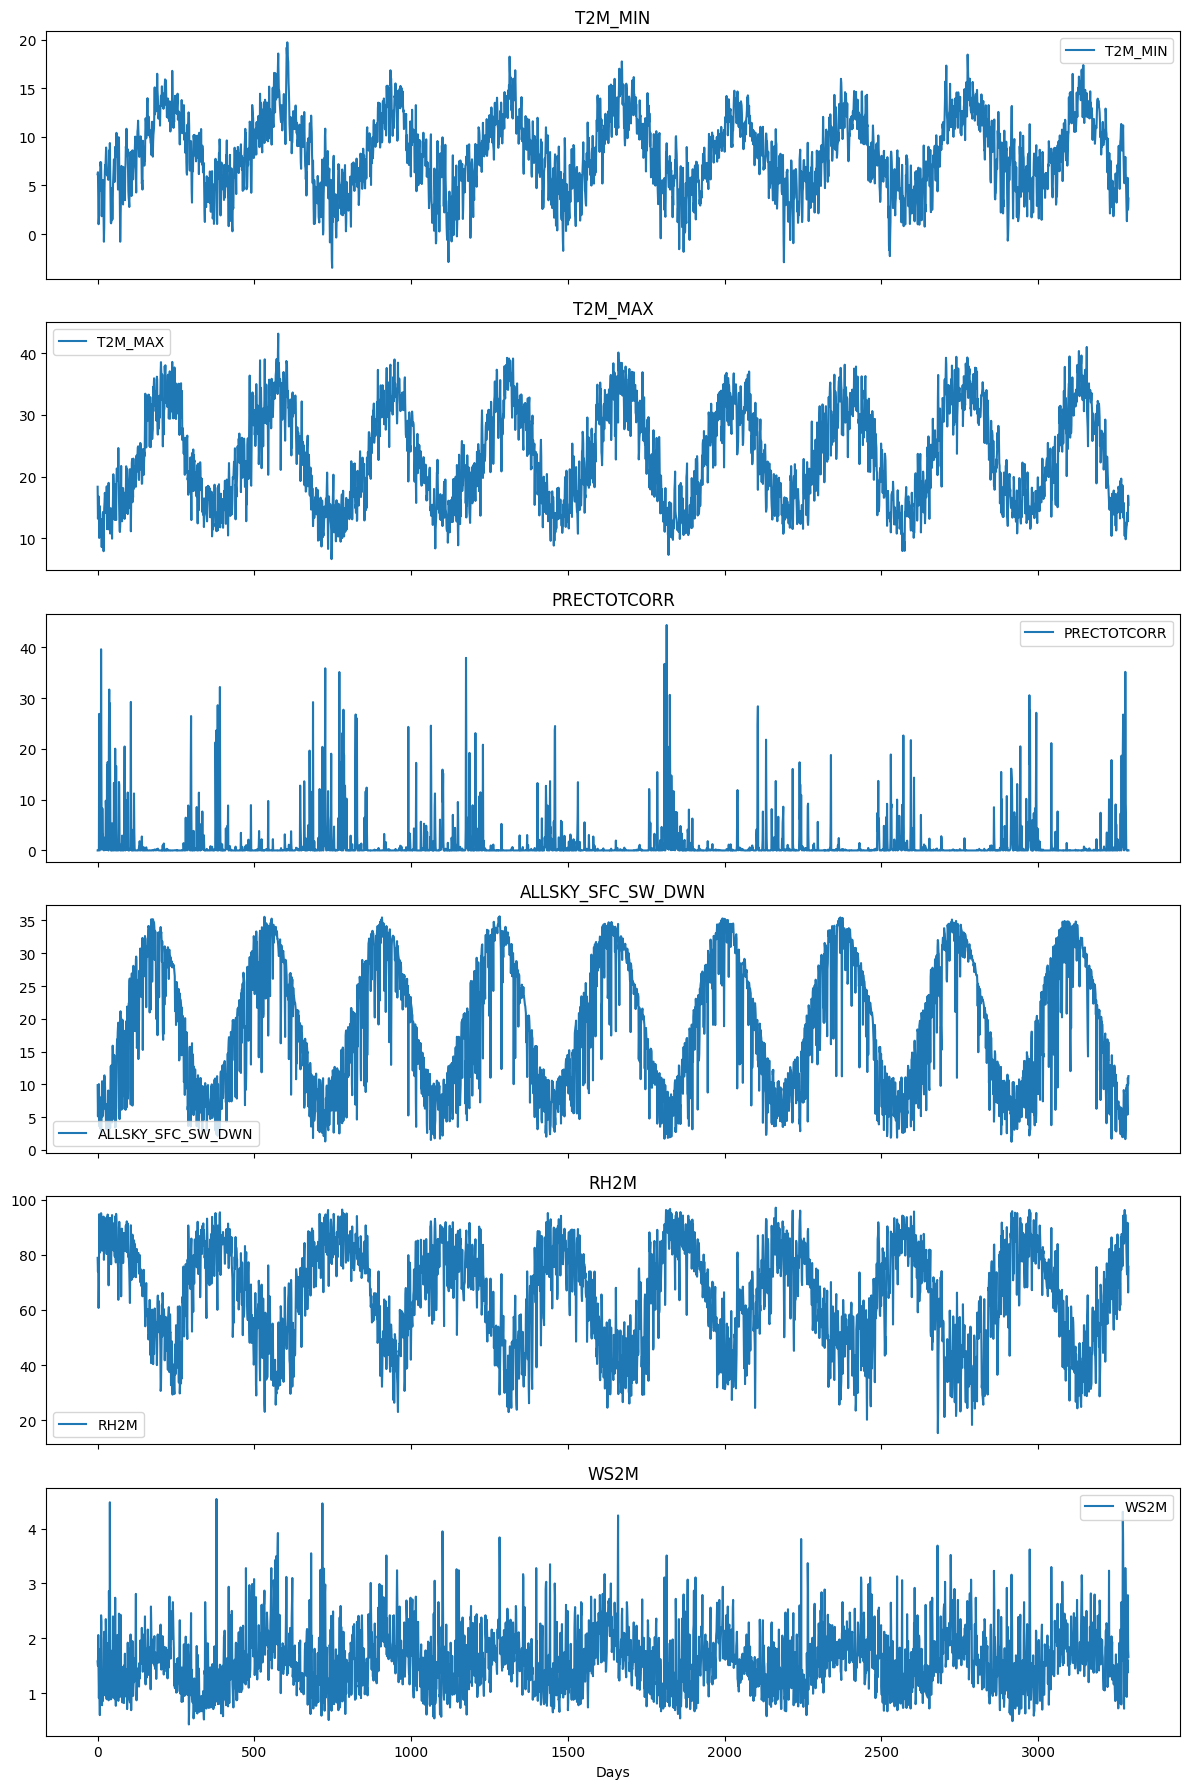

In [3]:
plot_complete_data(X, columns)

In [4]:
CTX = 30
HORIZON = 60
dataset = WeatherPairs(X, ctx=CTX, horizon=HORIZON, stride=1)
train_ds, val_ds, test_ds = split_windows_train_val_test(dataset, test_frac=0.15, val_frac=0.15, train_frac=0.7)



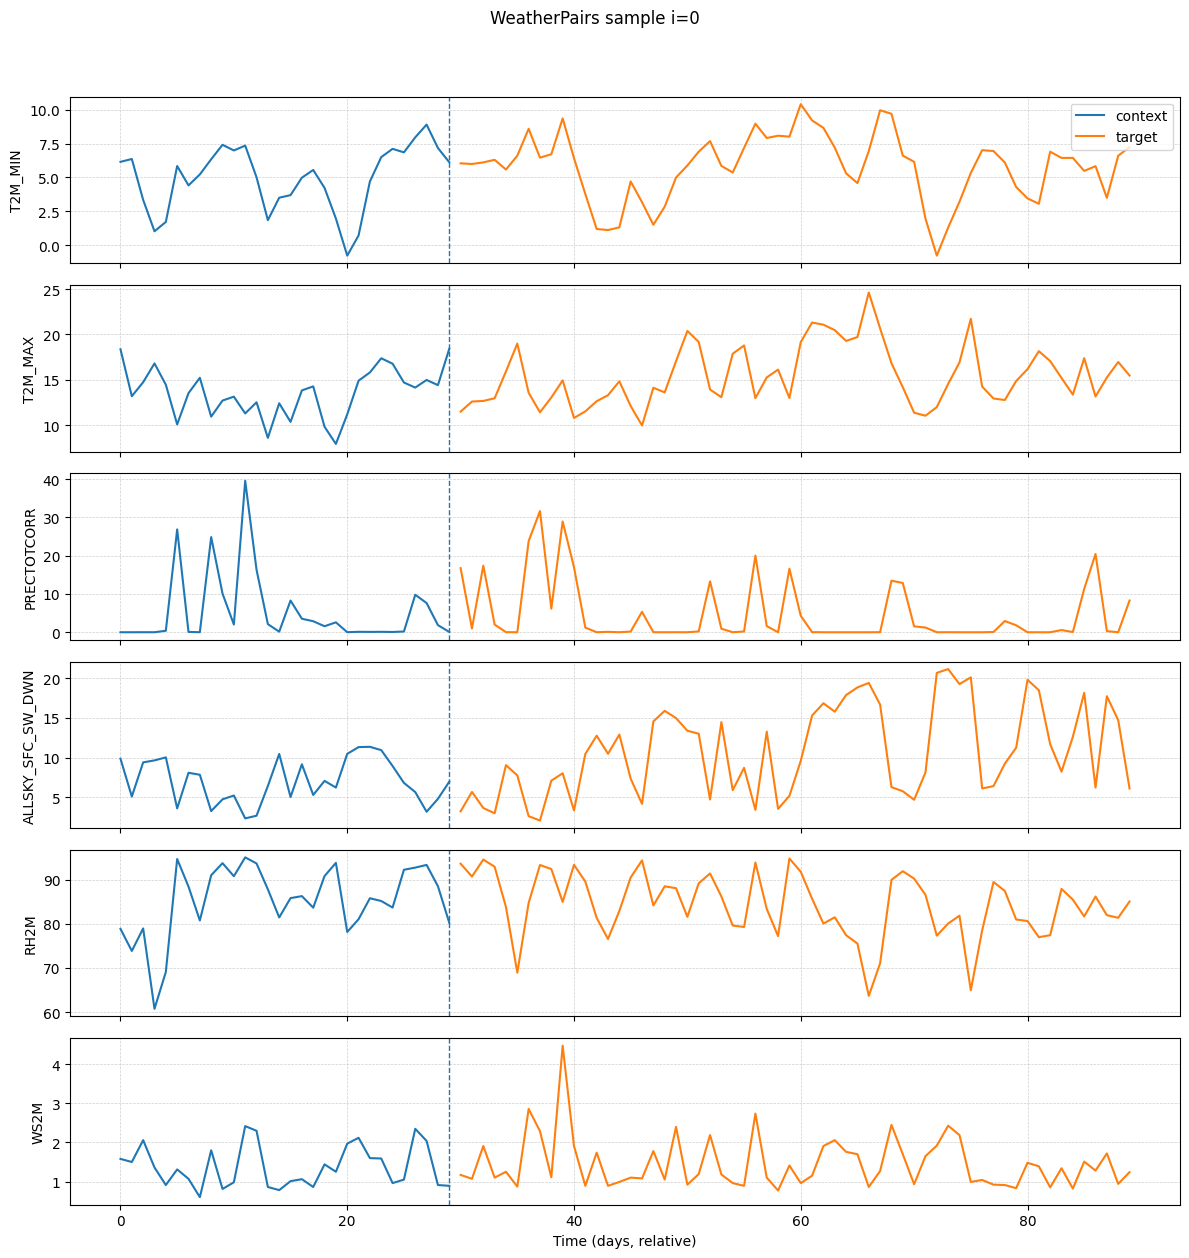

In [5]:
plot_weatherpair_panel(train_ds, i=0, feature_names=feature_names)

In [6]:
print("windows:", len(dataset))
print("train/val/test:", len(train_ds), len(val_ds), len(test_ds))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, drop_last=False)


windows: 3200
train/val/test: 2060 480 480


In [7]:
mean, std = fit_standardizer(train_ds)
mean_t = torch.tensor(mean, device=device)
std_t = torch.tensor(std, device=device)
print("mean:", mean, "\nstd:", std)

mean: [ 8.459271  23.458063   1.2683116 19.288597  65.49253    1.5936227] 
std: [ 3.8053296  7.7660513  4.1309943  9.830346  17.798946   0.5622518]


In [8]:
sched = DiffusionSchedule(T=100)

In [9]:
model = TinyCondUNet1D(in_vars=VARS, ctx_vars=VARS).to(device)


epoch 01 | train 0.6704 | val 0.5253
epoch 02 | train 0.4821 | val 0.4774
epoch 03 | train 0.4377 | val 0.4508
epoch 04 | train 0.4180 | val 0.4456
epoch 05 | train 0.4128 | val 0.4170
epoch 06 | train 0.4073 | val 0.4376
epoch 07 | train 0.3933 | val 0.4267
epoch 08 | train 0.3841 | val 0.4307
epoch 09 | train 0.3834 | val 0.4338
epoch 10 | train 0.3689 | val 0.4094
epoch 11 | train 0.3669 | val 0.4217
epoch 12 | train 0.3611 | val 0.4234
epoch 13 | train 0.3612 | val 0.4629
epoch 14 | train 0.3622 | val 0.4259
epoch 15 | train 0.3507 | val 0.4748
epoch 16 | train 0.3498 | val 0.4580
epoch 17 | train 0.3420 | val 0.4349
epoch 18 | train 0.3410 | val 0.4334
epoch 19 | train 0.3433 | val 0.4434
epoch 20 | train 0.3470 | val 0.4539
epoch 21 | train 0.3370 | val 0.4344
epoch 22 | train 0.3374 | val 0.4559
epoch 23 | train 0.3301 | val 0.4761
epoch 24 | train 0.3201 | val 0.4632
epoch 25 | train 0.3182 | val 0.4694
epoch 26 | train 0.3263 | val 0.4837
epoch 27 | train 0.3275 | val 0.4928
e

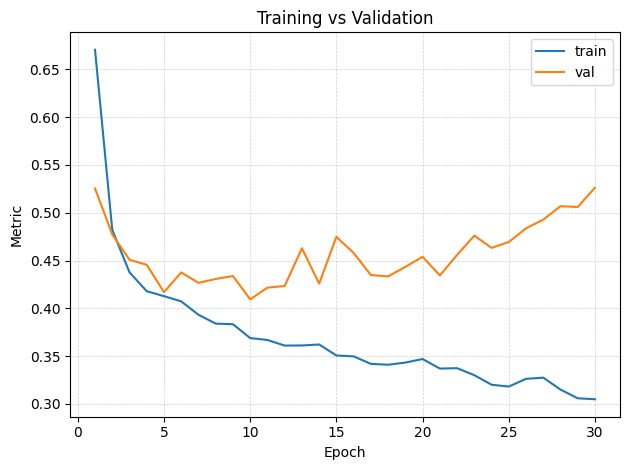

In [10]:
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

train_hist, val_hist = [], []

for e in range(1, EPOCHS + 1):
    tr = train_one_epoch(opt, model, sched, device, train_loader, mean_t, std_t)
    va = eval_epoch(model, device, val_loader, sched, mean_t, std_t)

    train_hist.append(float(tr))
    val_hist.append(float(va))

    print(f"epoch {e:02d} | train {tr:.4f} | val {va:.4f}")

visualize_loss(EPOCHS, train_hist, val_hist)


In [11]:
ctx_raw, tgt_raw = val_ds[0]
ctx_raw = ctx_raw.unsqueeze(0)  # (1,60,6)
tgt_raw = tgt_raw.numpy()       # (60,6)

scens = p_sample_loop(ctx_raw, model, device, sched, HORIZON, VARS, 
                      mean_t, std_t, n_scenarios=20).numpy() 
days = np.arange(HORIZON)


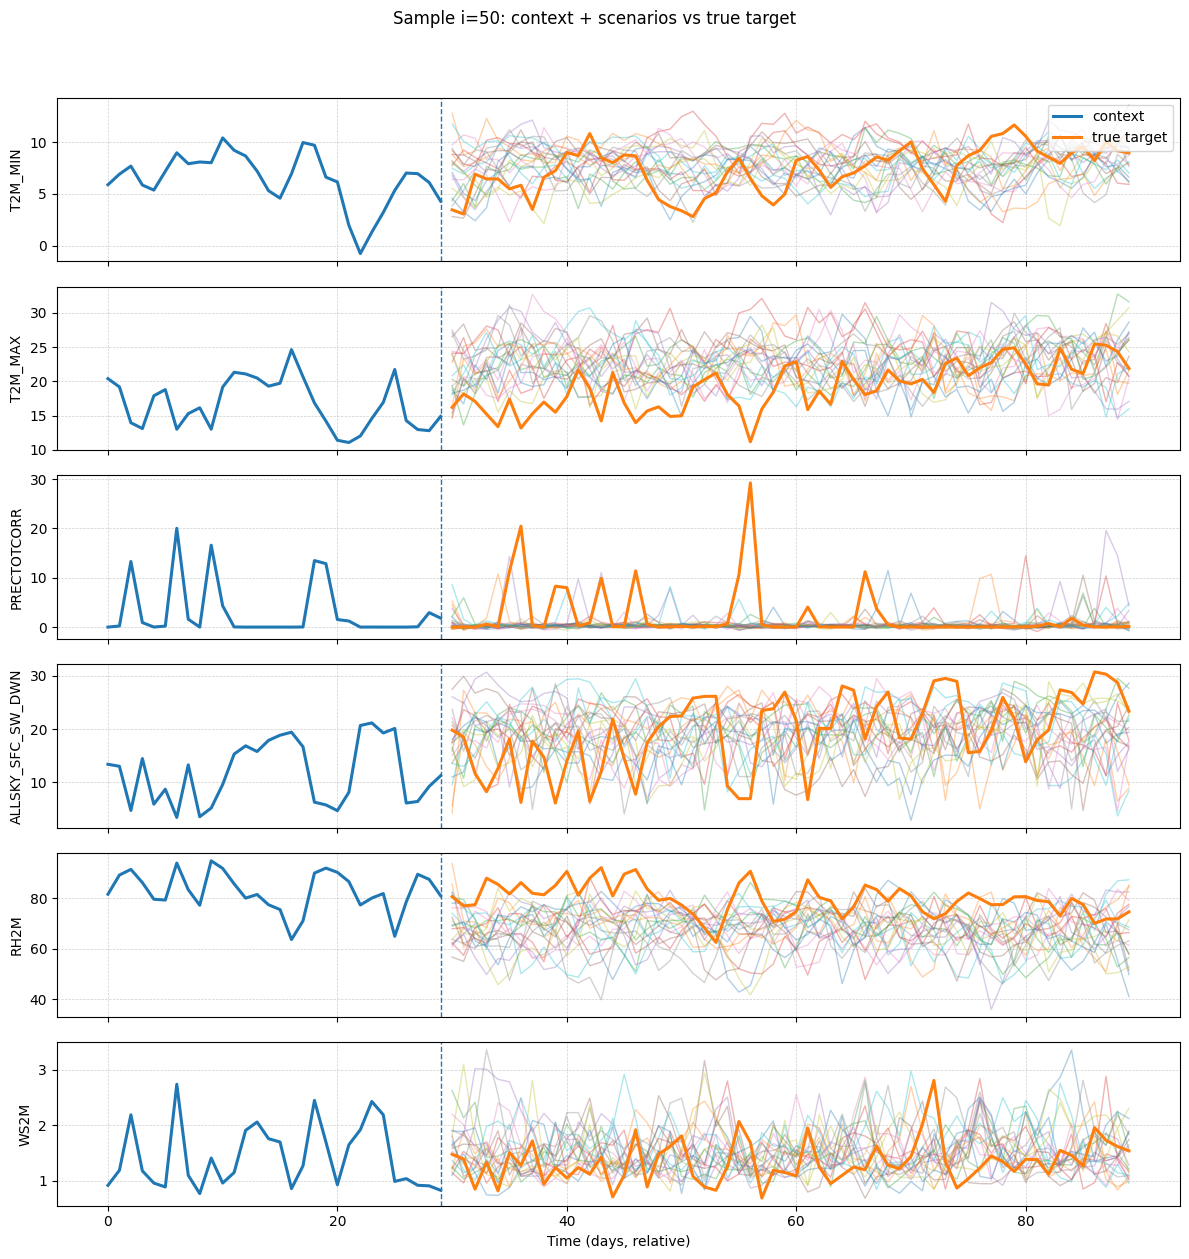

In [12]:
# Get one validation sample
ctx_raw, tgt_raw = val_ds[0]
ctx_raw = ctx_raw.unsqueeze(0)  # (1,CTX,VARS)

# Generate scenarios: (n_scenarios, HORIZON, VARS)
scens = p_sample_loop(ctx_raw, model, device, sched, HORIZON, VARS,
                      mean_t, std_t, n_scenarios=20).detach().cpu().numpy()

plot_ctx_and_scenarios_panel(
    dataset,
    50,
    scens,
    feature_names=feature_names,
    max_scen_to_plot=100
)


In [13]:
np.save("scenarios.npy", scens)

In [14]:
Omega = np.load("scenarios.npy")
Omega

array([[[ 1.27910452e+01,  1.63471889e+01,  5.25403786e+00,
          4.31510925e+00,  8.56227341e+01,  1.23055494e+00],
        [ 8.76816559e+00,  2.51424160e+01,  3.05853903e-01,
          2.73151932e+01,  6.05269318e+01,  1.89003634e+00],
        [ 9.11714363e+00,  2.56364861e+01, -6.72482252e-02,
          2.30049610e+01,  6.70277023e+01,  1.48506689e+00],
        ...,
        [ 9.88959789e+00,  2.47435417e+01,  5.47407866e-02,
          1.81960011e+01,  7.65636749e+01,  1.01837778e+00],
        [ 1.01685152e+01,  1.80722713e+01,  1.25815761e+00,
          6.48967457e+00,  7.95267258e+01,  8.92762780e-01],
        [ 1.05575066e+01,  2.15418854e+01,  7.08554029e-01,
          8.93894291e+00,  8.47863846e+01,  9.91810203e-01]],

       [[ 4.34123373e+00,  2.02761917e+01,  1.30783558e+00,
          2.13683777e+01,  6.89462280e+01,  2.62807035e+00],
        [ 5.99180174e+00,  1.93095646e+01,  4.98050511e-01,
          1.81251640e+01,  7.03535004e+01,  2.13543558e+00],
        [ 3.74296